# Importing Libraries

In [ ]:
import os
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import itertools
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM, SpatialDropout1D, Embedding
from keras.utils.np_utils import to_categorical
import keras

# Reading the dataset and arranging the emails and labels into lists.

In [ ]:
emails = []
labels = []
path = '/kaggle/input/ham-and-spam-dataset/hamnspam/'

for label in ['ham','spam']:
    files = os.listdir(path + label)
    for file in files:
        f = open((path + label+'/' + file), 'r', encoding = 'latin-1')
        b = f.read()
        emails.append(b)
        labels.append(label)

# Creating a pandas dataset from the 2 lists for better convinence during data visualization and pre-processing

In [ ]:
df = pd.DataFrame({'emails': emails, 'labels': labels})
df

,emails,labels
0,From fork-admin@xent.com Tue Sep 17 18:42:38 ...,ham
1,From rssfeeds@jmason.org Tue Sep 24 10:47:46 ...,ham
2,From rpm-list-admin@freshrpms.net Mon Sep 9 ...,ham
3,From exmh-workers-admin@redhat.com Fri Aug 23...,ham
4,From fork-admin@xent.com Fri Aug 23 11:08:39 ...,ham
...,...,...
3047,From michaelrobbins012389150776@hotmail.com T...,spam
3048,From fholland@bigfoot.com Wed Sep 11 19:43:52...,spam
3049,From guage_420@aol.com Wed Sep 25 10:29:07 20...,spam
3050,From zzzz@listmgmt.com Mon Sep 2 12:15:03 20...,spam


# Visualizing data distribution.

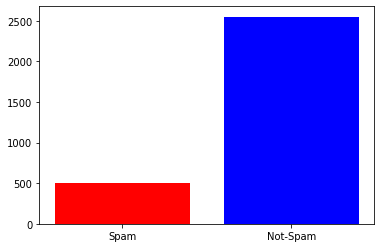

In [ ]:
plt.bar('Spam', len(os.listdir('/kaggle/input/ham-and-spam-dataset/hamnspam/spam/')), color='r')
plt.bar('Not-Spam',len(os.listdir('/kaggle/input/ham-and-spam-dataset/hamnspam/ham/')), color='b')
plt.show()

# Visualizing most commonly used words

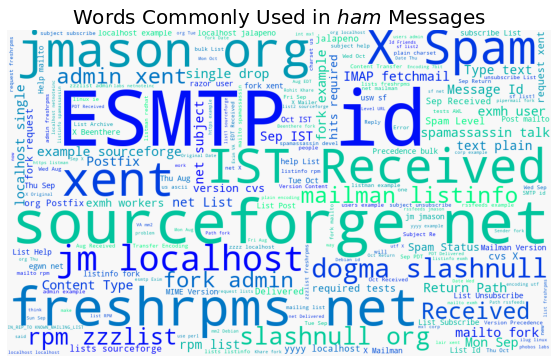

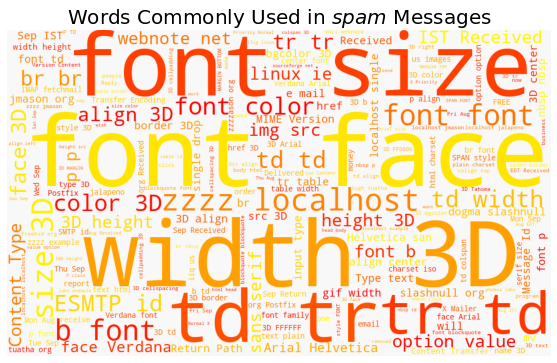

In [ ]:
for label, cmap in zip(["ham", "spam"], ["winter", "autumn"]):
    text = df.query("labels == @label")["emails"].str.cat(sep=" ")
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600, background_color="#f8f8f8", colormap=cmap)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

# Visualizing the length disstribution of the content in the emails.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'email length distribution')

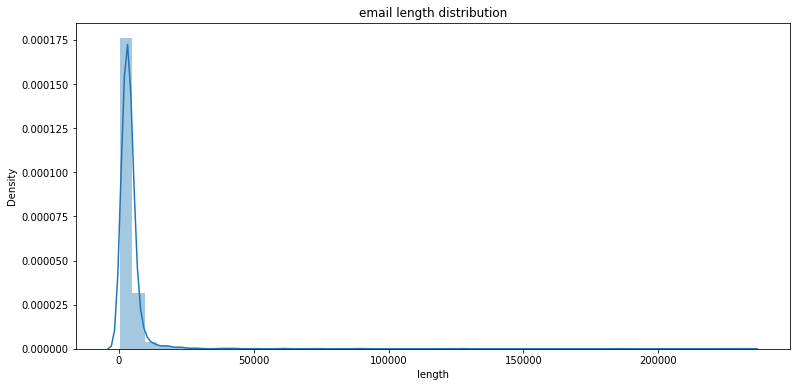

In [ ]:
df['length'] = df['emails'].str.len()
plt.figure(figsize=(12.8,6))
sns.distplot(df['length']).set_title('email length distribution')

In [ ]:
df['length'].describe()

count      3052.000000
mean       4149.719528
std        7278.653344
min         368.000000
25%        2013.500000
50%        3358.000000
75%        4497.250000
max      232337.000000
Name: length, dtype: float64

# removing from the 95% percentile onwards to better understanding of the histogram:

In [ ]:
quantile_95 = df['length'].quantile(0.95)
df_95 = df[df['length'] < quantile_95]

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


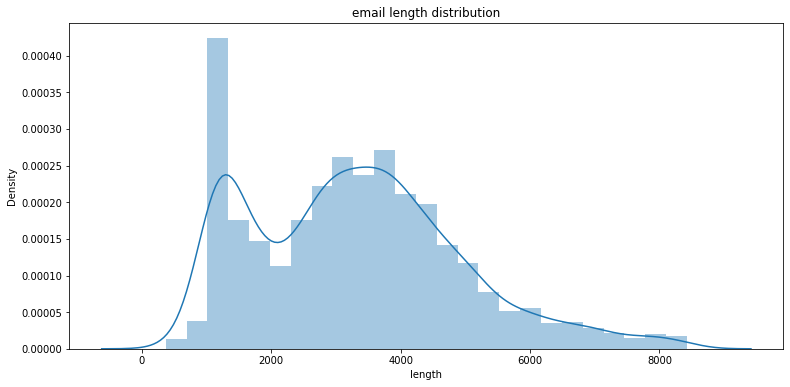

In [ ]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['length']).set_title('email length distribution');

# Visualizing using boxplot

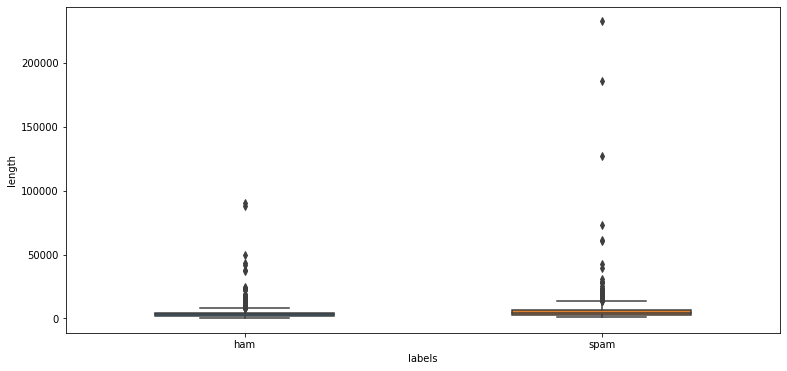

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='labels', y='length', width=.5);

# Visualizing after removing from the 95% percentile onwards to better understanding of the boxplot:

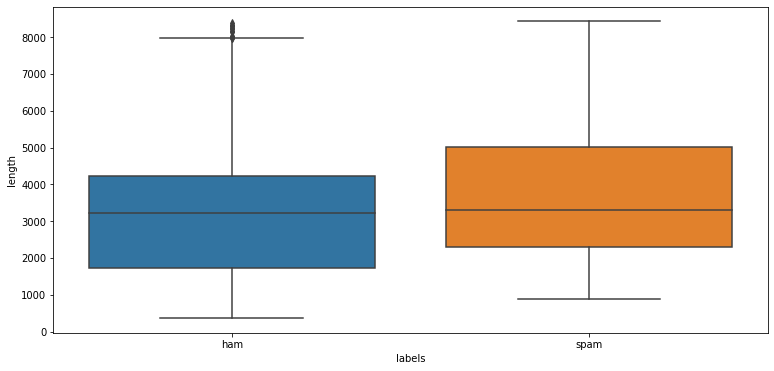

In [ ]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='labels', y='length');

# Checking for missing data

In [ ]:
print(df.isnull().sum())

emails    0
labels    0
length    0
dtype: int64


#### there is no missing data

# Converting the data into lower case.

In [ ]:
df['emails'] = df['emails'].apply(lambda x:x.lower())

# removing punctuations

In [ ]:
punctuation_signs = list("?:!.,;")
df['emails'] = df['emails']

for punct_sign in punctuation_signs:   
    df['emails'] = df['emails'].str.replace(punct_sign, '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """


# removing words with small lengths

In [ ]:
for i in range(len(df)):
    long_words=[]
    for j in df['emails'][i].split():
        if len(j)>=3:                  
            long_words.append(j)
    df['emails'][i]=" ".join(long_words)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Removing '\n' and '\t'.

In [ ]:
df['emails'] = df['emails'].apply(lambda x: x.replace('\n', ' '))
df['emails'] = df['emails'].apply(lambda x: x.replace('\t', ' '))

# Removing extra spaces

In [ ]:
df['emails'] = df['emails'].str.replace("    ", " ")

# Removing quoting text

In [ ]:
df['emails'] = df['emails'].str.replace('"', '')

# removing progressive pronouns

In [ ]:
df['emails'] = df['emails'].str.replace("'s", "")

# Lemmatization

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
nrows = len(df)
lemmatized_text_list = []
for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['emails']
    text_words = str(text).split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [ ]:
df['emails'] = lemmatized_text_list

# Removing Stop-words

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = list(stopwords.words('english'))

In [ ]:
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['emails'] = df['emails'].str.replace(regex_stopword, '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


# Encoding labels by converting 'ham' to 0 and 'spam' to 1.

In [ ]:
encoder = LabelEncoder()
df['labels'] = encoder.fit_transform(df['labels'])

# Using Bag of Words approach for final data Preparation.

In [ ]:
cv = CountVectorizer(max_features = 2500)
X = cv.fit_transform(df['emails']).toarray()
y = df['labels']

# Splitting the Data using Stratified split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Using MultiNomial Naive Bayes as the Model and evaluating it using confusion matrix

accuracy is:  0.982532751091703


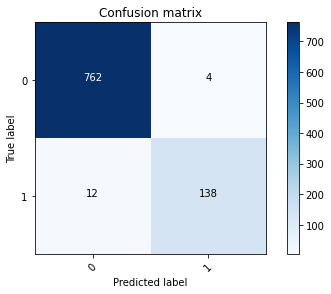

In [ ]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using SVC as the Model and evaluating it using confusion matrix

accuracy is:  0.9836244541484717


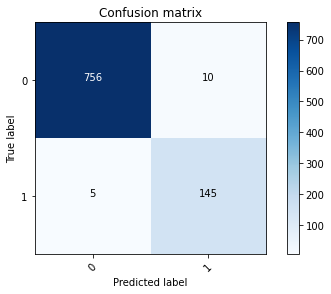

In [ ]:
clf = SVC(kernel='rbf', probability=True)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using KNeighbors Classifier as the Model and evaluating it using confusion matrix

accuracy is:  0.9836244541484717


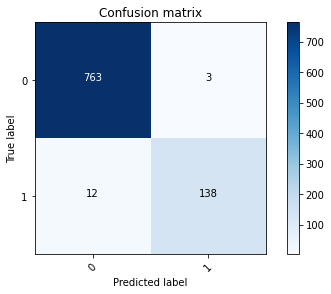

In [ ]:
clf = KNeighborsClassifier(n_neighbors=7)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using Random Forest Classifier as the Model and evaluating it using confusion matrix

accuracy is:  0.9912663755458515


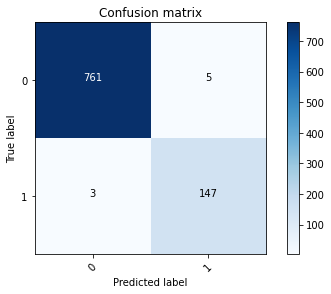

In [ ]:
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using Decision tree as the Model and evaluating it using confusion matrix

accuracy is:  0.9978165938864629


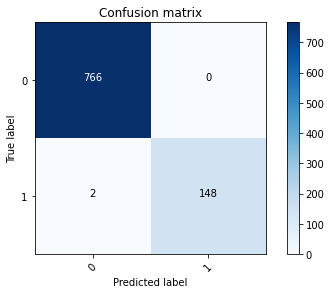

In [ ]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Using AdaBoost Classifier as the Model and evaluating it using confusion matrix

accuracy is:  1.0


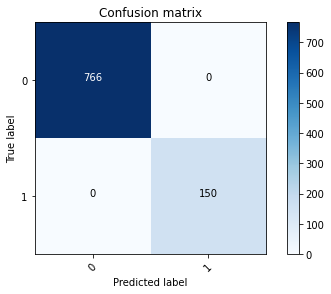

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("accuracy is: ",accuracy)
CM = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(CM, classes = range(2))

# Changing labels to categorical data

In [ ]:
y_train=to_categorical(y_train, num_classes = 2, dtype='float32')
y_test=to_categorical(y_test, num_classes = 2, dtype='float32')

# Creating an RNN Model and visualizing it

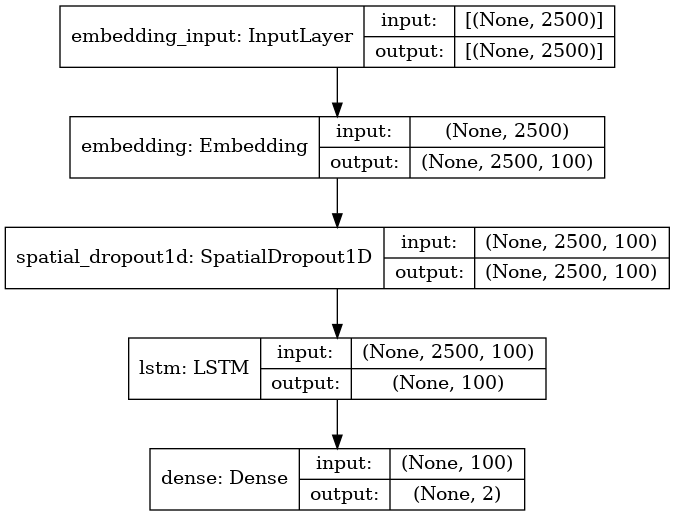

In [ ]:
model = Sequential()
model.add(Embedding(232337, 100, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 64

keras.utils.plot_model(model, show_shapes=True)


# Training the model

In [ ]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/10
34/34 [==============================] - 194s 5s/step - loss: 0.5649 - accuracy: 0.7695 - val_loss: 0.4328 - val_accuracy: 0.8362
Epoch 2/10
34/34 [==============================] - 179s 5s/step - loss: 0.4307 - accuracy: 0.8305 - val_loss: 0.3501 - val_accuracy: 0.8362
Epoch 3/10
34/34 [==============================] - 188s 6s/step - loss: 0.2969 - accuracy: 0.8562 - val_loss: 0.2129 - val_accuracy: 0.9148
Epoch 4/10
34/34 [==============================] - 202s 6s/step - loss: 0.2163 - accuracy: 0.9017 - val_loss: 0.1832 - val_accuracy: 0.9279
Epoch 5/10
34/34 [==============================] - 207s 6s/step - loss: 0.1961 - accuracy: 0.9049 - val_loss: 0.1653 - val_accuracy: 0.9279
Epoch 6/10
34/34 [==============================] - 196s 6s/step - loss: 0.1583 - accuracy: 0.9272 - val_loss: 0.1488 - val_accuracy: 0.9378
Epoch 7/10
34/34 [==============================] - 194s 6s/step - loss: 0.1474 - accuracy: 0.9335 - val_loss: 0.1382 - val_accuracy: 0.9476
Epoch 8/10
34

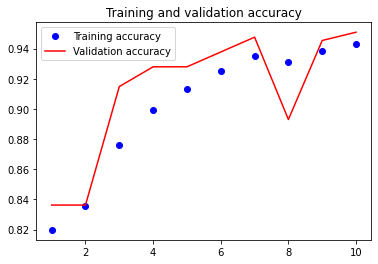

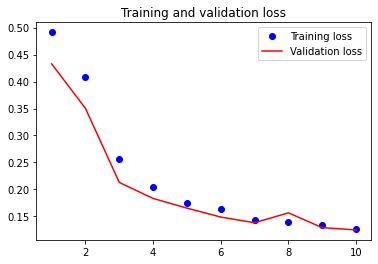

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()